In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Imputer

In [323]:
data=pd.read_csv('titanic.csv')
#print(data.info())
#data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


In [4]:
## column no. 0,3,8,10,11 are not relevant for model building
columns_to_remove=['PassengerId','Name','Ticket','Cabin','Embarked']
data_clean=data.drop(columns=columns_to_remove,axis=1)
data_clean.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [5]:
le=LabelEncoder()
data_clean['Sex'] = le.fit_transform(data_clean['Sex'])
data_clean = data_clean.fillna(data_clean['Age'].mean())

dataX=data_clean[['Pclass','Sex','Age','SibSp','Parch','Fare']]
dataY=data_clean['Survived']

In [6]:
dataX.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,1,22.0,1,0,7.2500
1,1,0,38.0,1,0,71.2833
2,3,0,26.0,0,0,7.9250
3,1,0,35.0,1,0,53.1000
4,3,1,35.0,0,0,8.0500


In [7]:
# Handling Missing Values (Imputer Class in Sklearn)
# im=Imputer(strategy='median')
# dataX=im.fit_transform(dataX))
# dataX.columns=[['Pclass','Sex','Age','SibSp','Parch','Fare']]
# dataX.head()

## Implementing entropy and information gain functions

In [69]:
def entropy(data,col):
    counts=np.unique(data[col],return_counts=True)
    entropy=0.0
    for i in counts[1]:
        p=i/data.shape[0]
        entropy+=-(p)*np.log2(p)
    return entropy   


In [244]:
def divideData(data,fcol,fval):
    left = pd.DataFrame(columns=data.columns)
    right = pd.DataFrame(columns=data.columns)
    
    for i in range(data.shape[0]):
        val = data[fcol].iloc[i]
        if val<=fval:
            left=left.append(data.iloc[i])
        else:
            right=right.append(data.iloc[i])
    return left,right

In [230]:
def informationGain(data,fcol,fval):
    left,right=divideData(data,fcol,fval)
    
    l=left.shape[0]/dataX.shape[0]
    r=right.shape[0]/dataX.shape[0]
    
    if left.shape[0]==0 or right.shape[0]==0:
        return -100000
    
    infoGain= entropy(data,'Survived') - l*entropy(left,'Survived') - r*entropy(right,'Survived')
    
    return infoGain

In [231]:
for col in dataX.columns:
    print(col,informationGain(data_clean,col,data_clean[col].mean()))

Pclass 0.07579362743608165
Sex 0.2176601066606143
Age 0.001158644038169343
SibSp 0.009584541813400127
Parch 0.015380754493137888
Fare 0.04214069283899541


## Implementing Decision Tree classifier Class

In [282]:
class DecisionTreeClassifier:
    def __init__(self,depth=0,max_depth=5):
        self.left=None
        self.right=None
        self.fval=None
        self.fkey=None
        self.depth=depth
        self.max_depth=max_depth
        self.target=None
    
    def fit(self,data):
        feature_cols=['Pclass','Sex','Age','SibSp','Parch','Fare']
        
        if data['Survived'].mean()>=0.5:    
            self.target=1
        else:
            self.target=0
        
        if entropy(data,'Survived') == 0.0 or self.depth>=self.max_depth:
            return    
        
        infoGain=[]
        for f in feature_cols:
            infoGain.append( informationGain(data,f,data[f].mean()) )
        
        self.fkey=feature_cols[np.argmax(infoGain)]
        self.fval=data[self.fkey].mean()
        
        data_left,data_right= divideData(data,self.fkey,self.fval)
        data_left=data_left.reset_index(drop=True)
        data_right=data_right.reset_index(drop=True)
        
        if data_left.shape[0]==0 or data_right.shape[0]==0:
            return
        
        #print('Node:: fkey = {}, fval = {}, target = {}'.format(self.fkey,self.fval,self.target))
        
        self.left = DecisionTreeClassifier(depth=self.depth+1,max_depth=self.max_depth)
        self.left.fit(data_left)
        self.right= DecisionTreeClassifier(depth=self.depth+1,max_depth=self.max_depth)
        self.right.fit(data_right)  
            
        return
    
    def predict(self,testX):
        if self.fkey is None:
            return self.target
        elif testX[self.fkey]>self.fval:
            if self.right is None:
                return self.target
            return self.right.predict(testX)
        else:
            if self.left is None:
                return self.target
            return self.left.predict(testX)
        
    def score(self,test_data):
        X=test_data[['Pclass','Sex','Age','SibSp','Parch','Fare']]
        Y=np.array(test_data['Survived'])
        count=0
        for i in range(test_data.shape[0]):
            if self.predict(X.loc[i])==Y[i]:
                count+=1
        return float(count/Y.shape[0])       

In [289]:
dt=DecisionTreeClassifier()

In [290]:
split = int(0.7*data_clean.shape[0])
train_data = data_clean[:split]
test_data = data_clean[split:]
test_data = test_data.reset_index(drop=True)
dt.fit(train_data)

In [305]:
print(dt.score(train_data))
print(dt.score(test_data))

0.8282504012841091
0.8171641791044776


## Using Sklearn

In [279]:
from sklearn.tree import DecisionTreeClassifier as dtc

In [307]:
sTree = dtc(criterion='entropy',max_depth=5)

input_cols=['Pclass','Sex','Age','SibSp','Parch','Fare']
sTree.fit(train_data[input_cols],train_data['Survived'])
print(sTree.score(train_data[input_cols],train_data['Survived']))
print(sTree.score(test_data[input_cols],test_data['Survived']))

0.8443017656500803
0.8283582089552238


## Random Forest

In [292]:
X_train = train_data[input_cols]
Y_train = np.array(train_data['Survived']).reshape((-1,))
X_test = test_data[input_cols]
Y_test = np.array(test_data['Survived']).reshape((-1,))

In [293]:
from sklearn.ensemble import RandomForestClassifier

In [313]:
## entropy
rtf = RandomForestClassifier(n_estimators=10,criterion='gini',max_depth=5)
rtf.fit(X_train,Y_train)

print(rtf.score(X_train,Y_train))
print(rtf.score(X_test,Y_test))

0.8571428571428571
0.832089552238806


In [312]:
## gini
rtf2 = RandomForestClassifier(n_estimators=10,criterion='gini',max_depth=5)
rtf2.fit(X_train,Y_train)

print(rtf2.score(X_train,Y_train))
print(rtf2.score(X_test,Y_test))

0.8443017656500803
0.832089552238806


In [316]:
from sklearn.model_selection import cross_val_score
acc = cross_val_score(RandomForestClassifier(n_estimators=22,max_depth=5,criterion='entropy'),X_train,Y_train,cv=5).mean()
print(acc)

0.8202527393753201


In [317]:
acc_list = []
for i in range(1,50):
    acc = cross_val_score(RandomForestClassifier(n_estimators=i,max_depth=5),X_train,Y_train,cv=5).mean()
    acc_list.append(acc)

In [318]:
import matplotlib.pyplot as plt

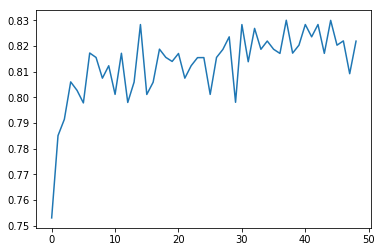

In [320]:
plt.plot(acc_list)
plt.show()